In [1]:
import numpy as np
import tensorflow as tf
tf.__version__

2023-06-20 05:06:16.992841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 05:06:17.987066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.12.0'

In [2]:
def process_text(file_path):
    text = open(path_to_file, 'r', encoding='utf-8', errors='replace').read()
    vocab = sorted(set(text))  # The unique characters in the file
    # Creating a mapping from unique characters to indices and vice versa
    char2idx = {u: i for i, u in enumerate(vocab)}
    idx2char = np.array(vocab)
    text_as_int = np.array([char2idx[c] for c in text])
    return text_as_int, vocab, char2idx, idx2char

In [3]:
def split_input_target(chunk):
    input_text, target_text = chunk[:-1], chunk[1:]
    return input_text, target_text

In [4]:
def create_dataset(text_as_int, seq_length=100, batch_size=64, buffer_size=10000):
    char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
    dataset = char_dataset.batch(seq_length + 1, drop_remainder=True).map(split_input_target)
    dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    return dataset

### Model1: 2 LSTM layers, With Regularization, Adam optimization, Epoch set = 50

In [5]:
def build_model(vocab_size, embedding_dim=256, rnn_units=1024, batch_size=64):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(vocab_size) # Default activation: 'linear'
    ])
    return model

In [6]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [7]:
def generate_text(model, char2idx, idx2char, start_string, generate_char_num=1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    # Low temperatures results in more predictable text, higher temperatures results in more surprising text.
    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []  # Empty string to store our results
    model.reset_states()
    for i in range(generate_char_num):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)    # remove the batch dimension
        predictions /= temperature
        # using a categorical distribution to predict the character returned by the model
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        # We pass the predicted character as the next input to the model along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], axis=0)
        text_generated.append(idx2char[predicted_id])
    return start_string + ''.join(text_generated)

In [8]:
# path_to_file = tf.keras.utils.get_file('nietzsche.txt', 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
path_to_file = 'Data/SherlockHolmes.txt'

text_as_int, vocab, char2idx, idx2char = process_text(path_to_file)
dataset = create_dataset(text_as_int)
model = build_model(vocab_size=len(vocab))
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()
history = model.fit(dataset, epochs=50)
model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
model = build_model(vocab_size=len(vocab), batch_size=1)
model.load_weights("gen_text_weights.h5")
model.summary()

2023-06-19 02:21:37.833396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9599 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:06:00.0, compute capability: 7.5
2023-06-19 02:21:38.602276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 02:21:38.606684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/spli

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           23296     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dropout (Dropout)           (64, None, 1024)          0         
                                                                 
 batch_normalization (BatchN  (64, None, 1024)         4096      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (64, None, 1024)          8392704   
                                                                 
 dropout_1 (Dropout)         (64, None, 1024)          0         
                                                        

2023-06-19 02:21:38.898856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 02:21:38.900703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 02:21:38.901860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

523/523 [==============================] - 47s 75ms/step - loss: 1.7588 - accuracy: 0.5055
Epoch 2/50
523/523 [==============================] - 37s 67ms/step - loss: 1.2982 - accuracy: 0.6069
Epoch 3/50
523/523 [==============================] - 37s 68ms/step - loss: 1.2105 - accuracy: 0.6295
Epoch 4/50
523/523 [==============================] - 37s 67ms/step - loss: 1.1594 - accuracy: 0.6431
Epoch 5/50
523/523 [==============================] - 37s 67ms/step - loss: 1.1212 - accuracy: 0.6534
Epoch 6/50
523/523 [==============================] - 37s 67ms/step - loss: 1.0891 - accuracy: 0.6622
Epoch 7/50
523/523 [==============================] - 37s 68ms/step - loss: 1.0610 - accuracy: 0.6703
Epoch 8/50
523/523 [==============================] - 37s 68ms/step - loss: 1.0356 - accuracy: 0.6773
Epoch 9/50
523/523 [==============================] - 37s 68ms/step - loss: 1.0102 - accuracy: 0.6846
Epoch 10/50
523/523 [==============================] - 37s 68ms/step - loss: 0.9867 - accurac

2023-06-19 02:52:45.333690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 02:52:45.335973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 02:52:45.338754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            23296     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dropout_2 (Dropout)         (1, None, 1024)           0         
                                                                 
 batch_normalization_2 (Batc  (1, None, 1024)          4096      
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (1, None, 1024)           8392704   
                                                                 
 dropout_3 (Dropout)         (1, None, 1024)           0         
                                                      

In [11]:
import matplotlib.pyplot as plt
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

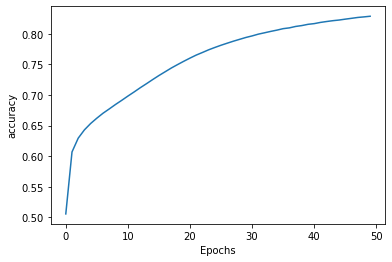

In [10]:
plot_graphs(history,'accuracy')

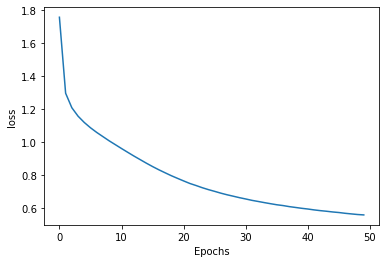

In [11]:
plot_graphs(history,'loss')

In [12]:
import time
user_input = input("Write the beginning of the text, the program will complete it. Your input is: ")
start = time.time()
generated_text = generate_text(model, char2idx, idx2char, start_string=user_input, generate_char_num=1000)
end = time.time()
print(generated_text)
print('\nRun time:', end - start)

Write the beginning of the text, the program will complete it. Your input is: There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was
There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was for the
     servant's things to be distunbed."

     "What should I know the matter of the Hall," said he, "but
     at that moment, Watson."

     "What does it show us in some ways?"

     "There are two faces was moving about the old hall before evil gives us a chance of their
     matters."

     Our visitor staggered. 

     "Yes," said McMurdo.

     "I stood with you as large and as resolute as seaman. I can see
     him more flew long enough. From acideto to carry out your order, and your attention to assure
     that she had resented for some time, but from the direction into the
     lower part of the bare side of the table. passing itself on the steps
     instantly wit

### Model2: 1 LSTM layer, Without Regularization, Adam optimization, Epoch set = 50

In [5]:
def build_model2(vocab_size, embedding_dim=256, rnn_units=1024, batch_size=64):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [9]:
# path_to_file = tf.keras.utils.get_file('nietzsche.txt', 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
path_to_file = 'Data/SherlockHolmes.txt'

text_as_int, vocab, char2idx, idx2char = process_text(path_to_file)
dataset = create_dataset(text_as_int)
model = build_model2(vocab_size=len(vocab))
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()
history = model.fit(dataset, epochs=50)
model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
model = build_model2(vocab_size=len(vocab), batch_size=1)
model.load_weights("gen_text_weights.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           23296     
                                                                 
 lstm_1 (LSTM)               (64, None, 1024)          5246976   
                                                                 
 dense_1 (Dense)             (64, None, 91)            93275     
                                                                 
Total params: 5,363,547
Trainable params: 5,363,547
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-06-19 03:32:23.724886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 03:32:23.728269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 03:32:23.730664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

523/523 [==============================] - 25s 37ms/step - loss: 1.9416 - accuracy: 0.4477
Epoch 2/50
523/523 [==============================] - 16s 27ms/step - loss: 1.3404 - accuracy: 0.5978
Epoch 3/50
523/523 [==============================] - 16s 28ms/step - loss: 1.2148 - accuracy: 0.6304
Epoch 4/50
523/523 [==============================] - 16s 28ms/step - loss: 1.1559 - accuracy: 0.6458
Epoch 5/50
523/523 [==============================] - 16s 27ms/step - loss: 1.1172 - accuracy: 0.6559
Epoch 6/50
523/523 [==============================] - 16s 27ms/step - loss: 1.0879 - accuracy: 0.6640
Epoch 7/50
523/523 [==============================] - 16s 28ms/step - loss: 1.0625 - accuracy: 0.6710
Epoch 8/50
523/523 [==============================] - 16s 27ms/step - loss: 1.0404 - accuracy: 0.6772
Epoch 9/50
523/523 [==============================] - 16s 27ms/step - loss: 1.0202 - accuracy: 0.6832
Epoch 10/50
523/523 [==============================] - 16s 27ms/step - loss: 1.0006 - accurac

2023-06-19 03:46:00.082115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 03:46:00.086628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 03:46:00.089894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

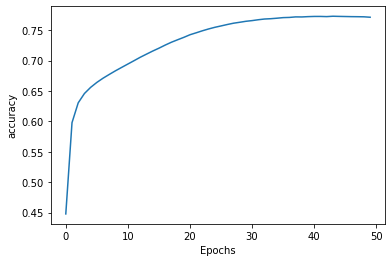

In [11]:
plot_graphs(history,'accuracy')

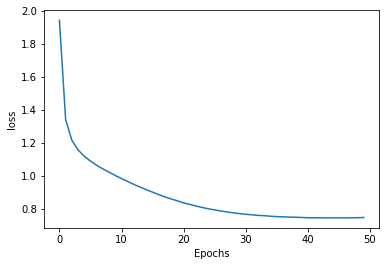

In [12]:
plot_graphs(history,'loss')

In [16]:
user_input = input("Write the beginning of the text, the program will complete it. Your input is: ")
start = time.time()
generated_text = generate_text(model, char2idx, idx2char, start_string=user_input, generate_char_num=1000)
end = time.time()
print(generated_text)
print('\nRun time:', end - start)

Write the beginning of the text, the program will complete it. Your input is: There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was
There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was that made me sech
     you, but I'm all at Yoxley Sir Henry, and you hang your career
     ringing after he is as far as I dragged y a group of disgream pieces from a rock-coat.

     "Yes," said I. "Your relations are fat, and I see to work I have made a
     bitter and courage  "We were exit down in all this. To running his brought feeling through the
     wind  "It will, dear me, it is too late to high it as a morning?"

     "Dear Sir:
     "Only my hand chin it was not an
     account of the little time before our already. But between ourselves, there will no light upon
     the stones to find the way down the streets of Francis's forbed. He took earn
     on West's would not 

### Model3: 1 LSTM layer, With Regularization, Adam optimization, Epoch set = 50

In [6]:
def build_model3(vocab_size, embedding_dim=256, rnn_units=1024, batch_size=64):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [9]:
# path_to_file = tf.keras.utils.get_file('nietzsche.txt', 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
path_to_file = 'Data/SherlockHolmes.txt'

text_as_int, vocab, char2idx, idx2char = process_text(path_to_file)
dataset = create_dataset(text_as_int)
model = build_model3(vocab_size=len(vocab))
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()
history = model.fit(dataset, epochs=50)
model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
model = build_model3(vocab_size=len(vocab), batch_size=1)
model.load_weights("gen_text_weights.h5")
model.summary()

2023-06-19 04:09:05.905199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9126 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:06:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           23296     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dropout (Dropout)           (64, None, 1024)          0         
                                                                 
 batch_normalization (BatchN  (64, None, 1024)         4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (64, None, 91)            93275     
                                                                 
Total params: 5,367,643
Trainable params: 5,365,595
Non-trainable params: 2,048
__________________________________________

2023-06-19 04:09:06.673915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 04:09:06.677936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 04:09:06.680906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-06-19 04:09:06.920826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [3381940]
	 [[{{node Placeholder/_0}}]]
2023-06-19 04:09:06.921240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [3381940]
	 [[{{node Placeholder/_0}}]]
2023-06-19 04:09:07.208661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

523/523 [==============================] - 27s 39ms/step - loss: 1.8920 - accuracy: 0.4603
Epoch 2/50
523/523 [==============================] - 18s 30ms/step - loss: 1.3870 - accuracy: 0.5836
Epoch 3/50
523/523 [==============================] - 17s 30ms/step - loss: 1.2329 - accuracy: 0.6254
Epoch 4/50
523/523 [==============================] - 17s 29ms/step - loss: 1.1595 - accuracy: 0.6453
Epoch 5/50
523/523 [==============================] - 17s 30ms/step - loss: 1.1116 - accuracy: 0.6579
Epoch 6/50
523/523 [==============================] - 17s 30ms/step - loss: 1.0755 - accuracy: 0.6678
Epoch 7/50
523/523 [==============================] - 17s 30ms/step - loss: 1.0447 - accuracy: 0.6763
Epoch 8/50
523/523 [==============================] - 17s 29ms/step - loss: 1.0173 - accuracy: 0.6845
Epoch 9/50
523/523 [==============================] - 17s 29ms/step - loss: 0.9918 - accuracy: 0.6916
Epoch 10/50
523/523 [==============================] - 17s 29ms/step - loss: 0.9684 - accurac

2023-06-19 04:23:41.420044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 04:23:41.424516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 04:23:41.427828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (1, None, 91)             93275     
                                                                 
Total params: 5,367,643
Trainable params: 5,365,595
Non-trainable params: 2,048
_________________________________________________________________


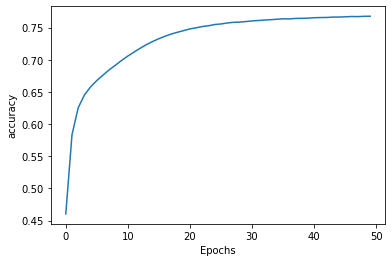

In [11]:
plot_graphs(history,'accuracy')

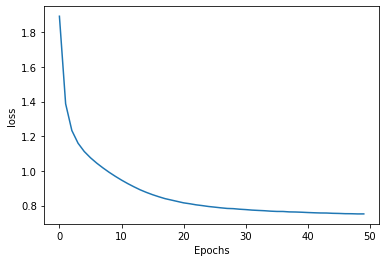

In [12]:
plot_graphs(history,'loss')

In [16]:
user_input = input("Write the beginning of the text, the program will complete it. Your input is: ")
start = time.time()
generated_text = generate_text(model, char2idx, idx2char, start_string=user_input, generate_char_num=1000)
end = time.time()
print(generated_text)
print('\nRun time:', end - start)

Write the beginning of the text, the program will complete it. Your input is: There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was
There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was with."

     "Well, I guess you sagged with the business you would not dare to speak
     enough.

     "I hardly wonder that you saw some days. If you will help her in that
     matter, Mr. Holmes?"

     A Freemens that we heard the chure fletting among the measured business which are of no other
     peculiar condition, but I have not known him even as a restrus of his left track.  But it
     was there, e down
     that energlic games. Al say?"

     "Were the lash of the driving papers there stood as a resolute world,
     and he were still emporience in
     waiting for him."

     "It's your boy. Yet no doubt was missed the matter on through a voice, in the country.
     So 

### Model4: 1 LSTM layer, With Regularization, SGD optimization, Epoch set = 50

In [5]:
def build_model3(vocab_size, embedding_dim=256, rnn_units=1024, batch_size=64):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [8]:
# path_to_file = tf.keras.utils.get_file('nietzsche.txt', 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
path_to_file = 'Data/SherlockHolmes.txt'

text_as_int, vocab, char2idx, idx2char = process_text(path_to_file)
dataset = create_dataset(text_as_int)
model = build_model3(vocab_size=len(vocab))
model.compile(optimizer='sgd', loss=loss, metrics=['accuracy'])
model.summary()
history = model.fit(dataset, epochs=50)
model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
model = build_model3(vocab_size=len(vocab), batch_size=1)
model.load_weights("gen_text_weights.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           23296     
                                                                 
 lstm_1 (LSTM)               (64, None, 1024)          5246976   
                                                                 
 dropout_1 (Dropout)         (64, None, 1024)          0         
                                                                 
 batch_normalization_1 (Batc  (64, None, 1024)         4096      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (64, None, 91)            93275     
                                                                 
Total params: 5,367,643
Trainable params: 5,365,595
Non-trainable params: 2,048
________________________________________

2023-06-19 04:39:36.393539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 04:39:36.395979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 04:39:36.397163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

523/523 [==============================] - 23s 34ms/step - loss: 3.5853 - accuracy: 0.2531
Epoch 2/50
523/523 [==============================] - 17s 30ms/step - loss: 2.7044 - accuracy: 0.3244
Epoch 3/50
523/523 [==============================] - 17s 29ms/step - loss: 2.4795 - accuracy: 0.3421
Epoch 4/50
523/523 [==============================] - 17s 29ms/step - loss: 2.3859 - accuracy: 0.3508
Epoch 5/50
523/523 [==============================] - 17s 29ms/step - loss: 2.3344 - accuracy: 0.3565
Epoch 6/50
523/523 [==============================] - 17s 29ms/step - loss: 2.3013 - accuracy: 0.3604
Epoch 7/50
523/523 [==============================] - 17s 30ms/step - loss: 2.2777 - accuracy: 0.3634
Epoch 8/50
523/523 [==============================] - 17s 30ms/step - loss: 2.2591 - accuracy: 0.3654
Epoch 9/50
523/523 [==============================] - 17s 29ms/step - loss: 2.2441 - accuracy: 0.3675
Epoch 10/50
523/523 [==============================] - 17s 29ms/step - loss: 2.2316 - accurac

2023-06-19 04:53:59.322360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 04:53:59.326740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 04:53:59.329648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 dense_2 (Dense)             (1, None, 91)             93275     
                                                                 
Total params: 5,367,643
Trainable params: 5,365,595
Non-trainable params: 2,048
_________________________________________________________________


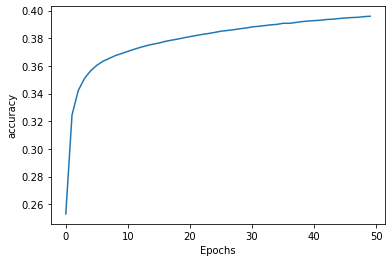

In [10]:
plot_graphs(history, 'accuracy')

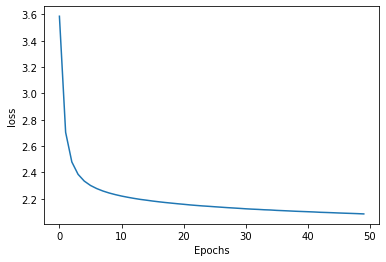

In [11]:
plot_graphs(history, 'loss')

In [15]:
user_input = input("Write the beginning of the text, the program will complete it. Your input is: ")
start = time.time()
generated_text = generate_text(model, char2idx, idx2char, start_string=user_input, generate_char_num=1000)
end = time.time()
print(generated_text)
print('\nRun time:', end - start)

Write the beginning of the text, the program will complete it. Your input is: There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was
There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was tore cofirenn
     withis live to blag the nol. Wed Hel perasin, Sintre, and sonencillis any he ben
     facored wasis thang afntit ny wing mat ha bes theve Hoy fow ave Hol thescry suit his ans aved popesthead queed incy uinde corme bate sat che, :at he I wat te gharind.

     tho tharo publent a tha couredoy chac baence nafldeen.

      "I wirkely  ou pot ingatin, ly ap alle hativly theed. My cally as weran caldde
    t she gotis sam gricoultobut h overeryen the and

     "For dande apyaly mum. Bon sor ghat e at paall ine withe cof ars bilds.

     I fouce poond---!"Yo I k*aldwe,, y ha  ounee ale9, fore
      s optim ant e wissurere id y supeders. To eman
     le thisur, been fist

### Model5: 1 LSTM layer, With Regularization, Adam optimization, Epoch set = 25

In [5]:
def build_model3(vocab_size, embedding_dim=256, rnn_units=1024, batch_size=64):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [11]:
# path_to_file = tf.keras.utils.get_file('nietzsche.txt', 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
path_to_file = 'Data/SherlockHolmes.txt'

text_as_int, vocab, char2idx, idx2char = process_text(path_to_file)
dataset = create_dataset(text_as_int)
model = build_model3(vocab_size=len(vocab))
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()
history = model.fit(dataset, epochs=25)
model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
model = build_model3(vocab_size=len(vocab), batch_size=1)
model.load_weights("gen_text_weights.h5")
model.summary()

2023-06-19 05:32:27.227119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 05:32:27.232858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 05:32:27.235887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (64, None, 256)           23296     
                                                                 
 lstm_4 (LSTM)               (64, None, 1024)          5246976   
                                                                 
 dropout_4 (Dropout)         (64, None, 1024)          0         
                                                                 
 batch_normalization_4 (Batc  (64, None, 1024)         4096      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (64, None, 91)            93275     
                                                                 
Total params: 5,367,643
Trainable params: 5,365,595
Non-trainable params: 2,048
________________________________________

2023-06-19 05:32:27.605683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [3381940]
	 [[{{node Placeholder/_0}}]]
2023-06-19 05:32:27.606035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [3381940]
	 [[{{node Placeholder/_0}}]]
2023-06-19 05:32:27.837750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

523/523 [==============================] - 22s 34ms/step - loss: 1.8950 - accuracy: 0.4596
Epoch 2/25
523/523 [==============================] - 17s 30ms/step - loss: 1.3927 - accuracy: 0.5823
Epoch 3/25
523/523 [==============================] - 17s 29ms/step - loss: 1.2352 - accuracy: 0.6248
Epoch 4/25
523/523 [==============================] - 17s 30ms/step - loss: 1.1607 - accuracy: 0.6448
Epoch 5/25
523/523 [==============================] - 17s 29ms/step - loss: 1.1134 - accuracy: 0.6572
Epoch 6/25
523/523 [==============================] - 17s 29ms/step - loss: 1.0767 - accuracy: 0.6676
Epoch 7/25
523/523 [==============================] - 17s 29ms/step - loss: 1.0461 - accuracy: 0.6762
Epoch 8/25
523/523 [==============================] - 17s 29ms/step - loss: 1.0184 - accuracy: 0.6841
Epoch 9/25
523/523 [==============================] - 17s 30ms/step - loss: 0.9931 - accuracy: 0.6915
Epoch 10/25
523/523 [==============================] - 17s 29ms/step - loss: 0.9694 - accurac

2023-06-19 05:39:41.050298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 05:39:41.054741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 05:39:41.057737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

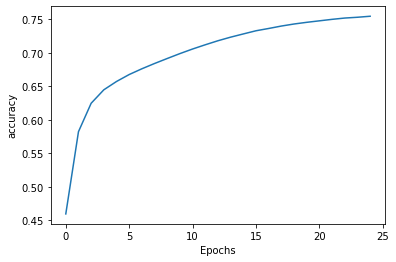

In [13]:
plot_graphs(history,'accuracy')

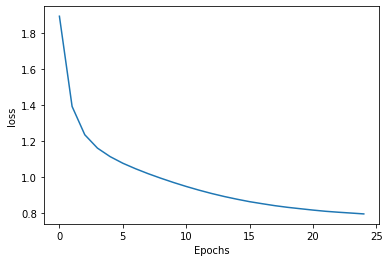

In [14]:
plot_graphs(history,'loss')

In [16]:
user_input = input("Write the beginning of the text, the program will complete it. Your input is: ")
start = time.time()
generated_text = generate_text(model, char2idx, idx2char, start_string=user_input, generate_char_num=1000)
end = time.time()
print(generated_text)
print('\nRun time:', end - start)

Write the beginning of the text, the program will complete it. Your input is: There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was
There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was that you are close to a
     loud. the effect pter. "It will be pose, strying her master
     as a composition that a good half surgeon that I had heard what he
     man put in any way, whenge  "There was," said
     John McMural, who was suggestive of times which the most
     unadvisible dden in one hand, and the first that they could have
     lost so story as the matter turned occasionally through my corrison, and
     near the poison or two things for which I say. Did you come to the world,
     Mr. Holmes, and it's not well in America. Come in my principal trained,
     indeed, one we will put them in a symp of it."

     "I'll be prepared to convey nothing on his rider."

  

### Model6: 2 LSTM layers, With Regularization, Adam optimization, Epoch set = 75

In [8]:
# path_to_file = tf.keras.utils.get_file('nietzsche.txt', 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
path_to_file = 'Data/SherlockHolmes.txt'

text_as_int, vocab, char2idx, idx2char = process_text(path_to_file)
dataset = create_dataset(text_as_int)
model = build_model(vocab_size=len(vocab))
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()
history = model.fit(dataset, epochs=75)
model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
model = build_model(vocab_size=len(vocab), batch_size=1)
model.load_weights("gen_text_weights.h5")
model.summary()

2023-06-19 11:49:33.605590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9599 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:06:00.0, compute capability: 7.5
2023-06-19 11:49:34.373897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 11:49:34.378604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/spli

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           23296     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dropout (Dropout)           (64, None, 1024)          0         
                                                                 
 batch_normalization (BatchN  (64, None, 1024)         4096      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (64, None, 1024)          8392704   
                                                                 
 dropout_1 (Dropout)         (64, None, 1024)          0         
                                                        

2023-06-19 11:49:34.665032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 11:49:34.666955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 11:49:34.668203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

523/523 [==============================] - 47s 74ms/step - loss: 1.7251 - accuracy: 0.5130
Epoch 2/75
523/523 [==============================] - 36s 66ms/step - loss: 1.2898 - accuracy: 0.6090
Epoch 3/75
523/523 [==============================] - 37s 68ms/step - loss: 1.2041 - accuracy: 0.6313
Epoch 4/75
523/523 [==============================] - 37s 67ms/step - loss: 1.1521 - accuracy: 0.6453
Epoch 5/75
523/523 [==============================] - 37s 67ms/step - loss: 1.1137 - accuracy: 0.6557
Epoch 6/75
523/523 [==============================] - 37s 68ms/step - loss: 1.0814 - accuracy: 0.6648
Epoch 7/75
523/523 [==============================] - 37s 67ms/step - loss: 1.0526 - accuracy: 0.6727
Epoch 8/75
523/523 [==============================] - 37s 67ms/step - loss: 1.0264 - accuracy: 0.6802
Epoch 9/75
523/523 [==============================] - 37s 67ms/step - loss: 1.0017 - accuracy: 0.6871
Epoch 10/75
523/523 [==============================] - 37s 67ms/step - loss: 0.9775 - accurac

2023-06-19 12:35:58.147667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 12:35:58.151713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 12:35:58.154429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


2023-06-19 12:35:58.451413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 12:35:58.454956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 12:35:58.457805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 embedding_1 (Embedding)     (1, None, 256)            23296     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dropout_2 (Dropout)         (1, None, 1024)           0         
                                                                 
 batch_normalization_2 (Batc  (1, None, 1024)          4096      
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (1, None, 1024)           8392704   
                                                                 
 dropout_3 (Dropout)         (1, None, 1024)           0         
                                                                 
 batch_normalization_3 (Batc  (1, None, 1024)          4096      
 hNormalization)                                                 
          

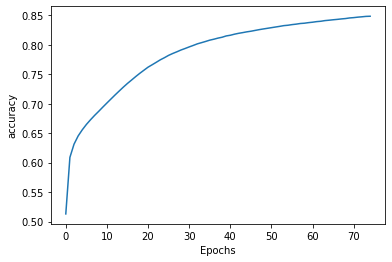

In [11]:
plot_graphs(history, 'accuracy')

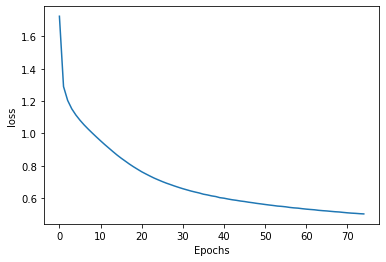

In [12]:
plot_graphs(history, 'loss')

In [13]:
user_input = input("Write the beginning of the text, the program will complete it. Your input is: ")
start = time.time()
generated_text = generate_text(model, char2idx, idx2char, start_string=user_input, generate_char_num=1000)
end = time.time()
print(generated_text)
print('\nRun time:', end - start)

Write the beginning of the text, the program will complete it. Your input is: There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was
There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was which surely the
     rves?  confidence in my friend Watson."

     "Then ho is the murderer?" Holmes cheery
     the only other things to be. I have already should think
     of it. I have thought that I would speak of what would be the matter with E. I'm sorry to begin with
     the position of the matter. Is all I know and what in the dying room
     were nearest his necktie.

     "I have told you all I know."

     Holmes shook his head with his hand, "I was not sure which; but I must disclose again, and I
     never went back from the back door."

     My companion's eyes were raised his eyebrows.

     "The community is possible," said Holmes. "Is it possible that I may be p

### Model7: 

In [9]:
def build_model(vocab_size, embedding_dim=256, batch_size=64):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(units = 1024, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LSTM(units = 512, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(vocab_size) # Default activation: 'linear'
    ])
    return model

In [10]:
# path_to_file = tf.keras.utils.get_file('nietzsche.txt', 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
path_to_file = 'Data/SherlockHolmes.txt'

text_as_int, vocab, char2idx, idx2char = process_text(path_to_file)
dataset = create_dataset(text_as_int)
model = build_model(vocab_size=len(vocab))
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()
history = model.fit(dataset, epochs=50)
model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
model = build_model(vocab_size=len(vocab), batch_size=1)
model.load_weights("gen_text_weights.h5")
model.summary()

2023-06-20 05:08:45.656927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-20 05:08:45.658754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-20 05:08:45.659938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           23296     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dropout (Dropout)           (64, None, 1024)          0         
                                                                 
 batch_normalization (BatchN  (64, None, 1024)         4096      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (64, None, 512)           3147776   
                                                                 
 dropout_1 (Dropout)         (64, None, 512)           0         
                                                        

2023-06-20 05:08:45.902704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-20 05:08:45.904798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-20 05:08:45.906153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-06-20 05:08:46.139330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [3381940]
	 [[{{node Placeholder/_0}}]]
2023-06-20 05:08:46.140042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [3381940]
	 [[{{node Placeholder/_0}}]]
2023-06-20 05:08:46.490597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

523/523 [==============================] - 37s 57ms/step - loss: 1.7330 - accuracy: 0.5105
Epoch 2/50
523/523 [==============================] - 27s 47ms/step - loss: 1.3175 - accuracy: 0.6031
Epoch 3/50
523/523 [==============================] - 26s 47ms/step - loss: 1.2176 - accuracy: 0.6290
Epoch 4/50
523/523 [==============================] - 27s 47ms/step - loss: 1.1584 - accuracy: 0.6443
Epoch 5/50
523/523 [==============================] - 26s 48ms/step - loss: 1.1179 - accuracy: 0.6555
Epoch 6/50
523/523 [==============================] - 27s 48ms/step - loss: 1.0863 - accuracy: 0.6642
Epoch 7/50
523/523 [==============================] - 27s 47ms/step - loss: 1.0601 - accuracy: 0.6714
Epoch 8/50
523/523 [==============================] - 27s 48ms/step - loss: 1.0370 - accuracy: 0.6778
Epoch 9/50
523/523 [==============================] - 27s 48ms/step - loss: 1.0168 - accuracy: 0.6835
Epoch 10/50
523/523 [==============================] - 27s 48ms/step - loss: 0.9979 - accurac

2023-06-20 05:31:21.048555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-20 05:31:21.052961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-20 05:31:21.056190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            23296     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dropout_2 (Dropout)         (1, None, 1024)           0         
                                                                 
 batch_normalization_2 (Batc  (1, None, 1024)          4096      
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (1, None, 512)            3147776   
                                                                 
 dropout_3 (Dropout)         (1, None, 512)            0         
                                                      

2023-06-20 05:31:21.450263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-20 05:31:21.452412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-20 05:31:21.454220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

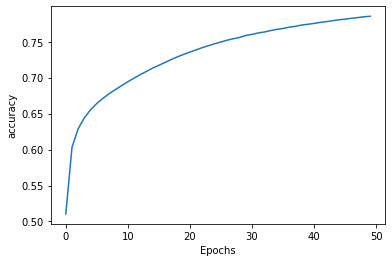

In [12]:
plot_graphs(history,'accuracy')

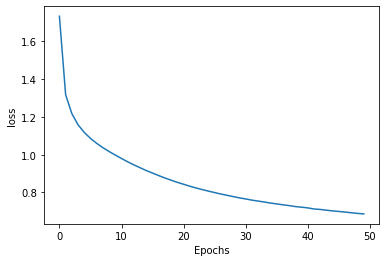

In [13]:
plot_graphs(history,'loss')

In [14]:
import time
user_input = input("Write the beginning of the text, the program will complete it. Your input is: ")
start = time.time()
generated_text = generate_text(model, char2idx, idx2char, start_string=user_input, generate_char_num=1000)
end = time.time()
print(generated_text)
print('\nRun time:', end - start)

Write the beginning of the text, the program will complete it. Your input is: There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was
There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was meant
     I was for an instant, and, after the envelope was already dried when me to seriously
     dis it. The detective was already through him and paced up and
     shoot in "I take it that you were on very intimately. But if you have the
     opportunity of a case of civilians, and craft so yours," he said; "it's not for use a wire. Wait a bit, he has not
     described to him that he poured bramble outline. The twisted more many small and sharps of smoke.
     But at least there is nothing to be arranged. It would be a
     specialist at the fury of those who have come to the dreadful
     lodge off bioord Parker; but the lamp was lit-handed, with a
     red eyes and pale, a 